<a href="https://colab.research.google.com/github/AlexNedyalkov/DeepLearning-SoftUni/blob/master/Using_ResNet_to_Improve_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.

In [1]:
# Detect Colab if present
try:
    from google.colab import drive
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: using Google CoLab
TensorFlow 2.x selected.


In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import Input, Flatten, MaxPooling2D, AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10



# Brief overview of "plain" neural networks for image recognition and how our intuition can lead us astray


Deep learning can be thought as learning an hierarchical sets of representations such that it can learn low, mid, and high level features. For example, when the data consist of images the low features mean learning edges, mid features mean learning to recognize different shapes, and high features mean  learning to recognize objects. Based on this, our intuition tells us that when designing a neural network we can improve its performance simply by stacking many of the typical building blocks such as convolutional or fully-connected layers one on top of the other. This works to a point, but performance quickly diminishes the deeper the traditional network becomes. 

![PlainNetworkPerformance](https://drive.google.com/uc?id=1lAry4bN_DEnSlZXTVndnbx0vCuYW9rX-)

source: Ander Ng Lectures on Convolutional Neural Networks

![ResNetVSCNN](https://drive.google.com/uc?id=1ur9Dt3MH8f4WlYVGnysrJ4uZvlBpQBy4)

source: He, et. al, 2015, Deep Residual Networks For Image Recognition



While intuitive the above logic does not work for the simple reason that adding more layers does not only make our network more expressive, but __it also makes it different__. What this means is that the set of functions that describe the data that are possible with this particular architecture changes from the set of functions that were possible before adding the extra layers and __there is no guarantee that the function that best describes the data would be in the new set of functions__. 

# An example of traditional CNN using the standard CIFAR-10 Library

## Brief description of the data

In this project I use the CIFAR-10 dataset, which is widely used for research purposes. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.


## Loading and exploring the data


In [3]:
cifar = datasets.cifar10

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

#Checking the shapes to make sure I have the right data
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)

print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)


# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0


#Would be need later for the CNN
input_shape = train_images.shape[1:]

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

Train images shape: (50000, 32, 32, 3)
Train labels shape: (50000, 1)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


Next to make sure that I got the right data and to better acquaint myself with the data I show sixteen of the images with their corresponding labels.

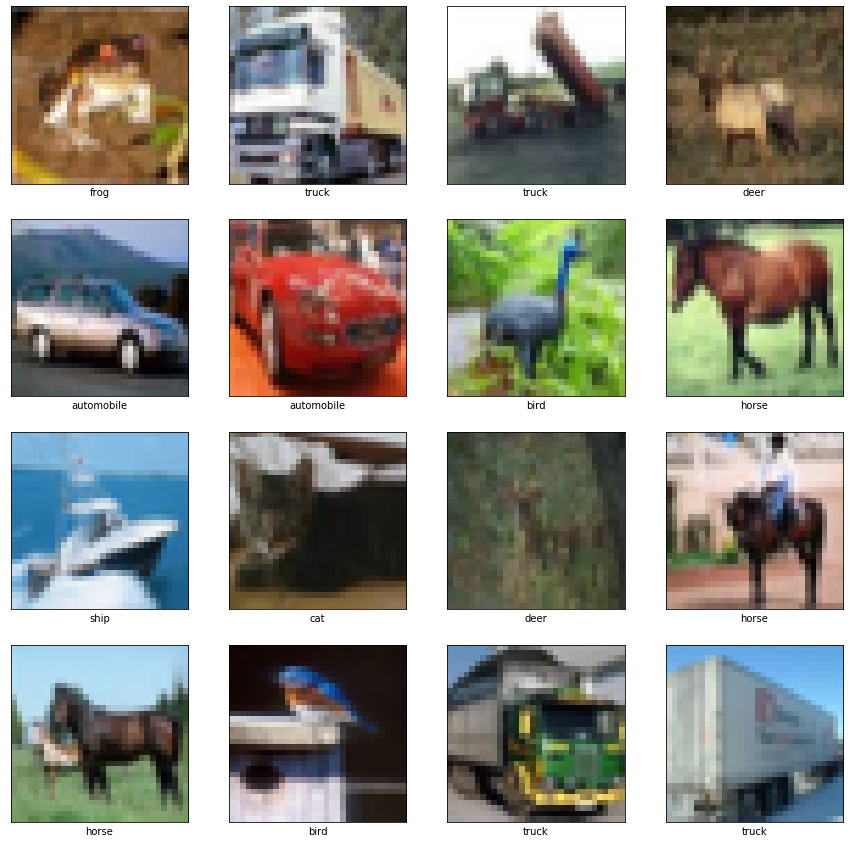

In [4]:
plt.figure(figsize=(15,15))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Model a "plain" CNN

### Create the convolutional base

I am going to start building my "plain" CNN by first constructing its convolutional base. I am using a basic CNN architecture: a stack of Conv2D and MaxPooling2D layers followed by batch normalization. As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. 


In [0]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = "relu", input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = "relu"))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization() )
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = "relu"))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())

In [16]:
# Checking the model after the first few layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 6, 64)          256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 128)         7

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network, while the third dimension defined by the number of filters increases. The total number of trainable parameters is 130560 which means that the model is not too big.



### Adding dense layers

To complete my model, I added several fully-connected layers. Since the dense layers take vectors as input and my the current output is a 3D tensor, first I  flatten the input to the first dense layer. My final Dense layer consists of 10 outputs since the dataset has 10 different categories and a softmax activation function.


In [6]:
model.add(Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 6, 64)          256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 128)         7

After adding the fully-connected layers the total number of trainable parameters increased to 216340.

Next I am going to compile the model using Adam for optimizer and sparse categorical crossentropy for loss function.

In [7]:
## Both, categorical cross entropy and sparse categorical cross entropy have the same loss function
## The only difference is the format in which you mention Yi (i,e true labels).

## If your Yi's are one-hot encoded, use categorical_crossentropy. 
## Examples (for a 3-class classification): [1,0,0] , [0,1,0], [0,0,1]

## But if your Yi's are integers, use sparse_categorical_crossentropy. 
## Examples for above 3-class classification problem: [1] , [2], [3]

model.compile(optimizer = "adam", loss = tf.keras.losses.sparse_categorical_crossentropy, metrics = ["accuracy"])

history = model.fit(train_images, train_labels, epochs=15, 
                    validation_data=(test_images, test_labels))


Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 14s 273us/sample - loss: 1.3919 - accuracy: 0.4990 - val_loss: 1.4622 - val_accuracy: 0.5040
Epoch 2/15
50000/50000 [==============================] - 7s 133us/sample - loss: 1.0614 - accuracy: 0.6236 - val_loss: 1.3011 - val_accuracy: 0.5764
Epoch 3/15
50000/50000 [==============================] - 7s 133us/sample - loss: 0.9244 - accuracy: 0.6733 - val_loss: 1.1350 - val_accuracy: 0.5877
Epoch 4/15
50000/50000 [==============================] - 7s 135us/sample - loss: 0.8244 - accuracy: 0.7119 - val_loss: 0.9145 - val_accuracy: 0.6826
Epoch 5/15
50000/50000 [==============================] - 7s 136us/sample - loss: 0.7516 - accuracy: 0.7389 - val_loss: 1.2076 - val_accuracy: 0.6109
Epoch 6/15
50000/50000 [==============================] - 7s 134us/sample - loss: 0.6929 - accuracy: 0.7581 - val_loss: 0.8817 - val_accuracy: 0.7014
Epoch 7/15
50000/50000 [=========================

From the above it is evident that the test accuracy of the "plain" CNN cannot exceed 0.70 even after being trained for 15 epochs. The train accuracy is over 0.82 so this means that we have the case in which the model is high bias and high variance at the same time. Furthermore on the  Tensorflow Tutorial page a similar network is build, which has a lot less layers and its test accuracy of 0.6954 is very similar to the performace of our CNN. Finally, on the Keras tutorial webpage there is another example of a 'plain" CNN, which is deeper than ours. After being trained for 50 epochs, this CNN manages to get its accuracy to 79%, which I still consider low and therefore even this model is high bias. 

__Based on all these and looking at the data itself and the fact that a human can recognize the different images in this dataset with much higher accuracy and therefore the Bayes optimal error, or the "real" error in the dataset, is considerably smaller than the one that we have achived with the "plain" CNNs we can conclude that the "plain" CNNs even with deeper layers are considerably underfitting the data__. 

# Step Forward Residual neural networks?

## Overview and basic intuitions
ResNet are based on the idea that every additional layer in the network should contain the identity function as one of its elements and thus guarantee that the set of possible functions describing the data in the deeper layers would include the set of possible functions describing the data in a shallower network. This logic was first implemented by adding residual blocks to a "plain" neural network and was illustrated in the following paper:

* K. He, X. Zhang, S. Ren, and J. Sun. [Deep residual learning for image recognition](https://arxiv.org/abs/1512.03385). arXiv preprint arXiv:1512.03385,2015.

## USEFUL EXPLANATIONS

The degradation problem mentioned in the paper is the authors’ observation that despite adding more layers to their net, they were obtaining lower training accuracy. The degradation problem is the observation that adding more layers to the net can lead to optimization problems, which do not allow the net to learn as well as a smaller net might. As mentioned before, this is counterintuitive, since we would assume that by giving our model more parameters, we should be able to fit the train data at least as well as before. __The authors of the  paper state that they trained their net with batch normalization and examined the gradients of the net, and the problem does not appear to be a case of vanishing gradients.__ Their conclusion was that the deeper network has a hard time learning the identity function for certain layers of the net, and may have an easier time learning zero mappings for those same layers: it is harder to learn f(x) = x, than f(x) = 0. Ultimately, this motivates their setup for learning small residuals and adding them to the input, rather than just transforming the whole input directly.


## Residual block

The structure of the residual block is presented below:

![SkipLayer](https://drive.google.com/uc?id=1iPDtyzwHQEeMqAsrS9pqliyNfRu_r9bn)

In a "plain" NN the input of the last relu activation function would be F(x). However, this becomes a problem if this particular layer does not "learn" anything useful and therefore we would much rather retain the input from the previous layer. The residual block on the other hand gives us the opportunity  to retain the value of the previous layer if no new information is learned in the residual block by setting F(x) = 0.

This means that if we can train the newly-added layer into an identity mapping 𝑓(𝐱)=𝐱, the new model will be as effective as the original model. As the new model may get a better solution to fit the training dataset, which means that the residual block learns something, the added layer might make it easier to reduce training errors. 

Residual blocks are typically used with convolutional neural networks (CNNs).  This allows very deep neural networks of CNNs to be created.  The following diagram shows several different ResNets as given by the abovementioned paper.

![ResNet](https://drive.google.com/uc?id=19m4LiVzaYzUKvRFoveXIE3isM9KGQI2H)

## Intuition How ResNet Work

To summarize, the basic intuition of the ResNets is that in the worst case scenario deeper model’s early layers can be replaced with the shallow network's layers and the remaining layers can just act as an identity function (Input equal to output). This why adding the residual block does not hurt the model. __However, if the residual units learn something useful then you can do even better than learning the activation function__. 



# Implementing ResNet in Keras

We start first by setting some hyperparameters that we would need later on.


In [0]:
# Training parameters
BATCH_SIZE = 32  # orig paper trained all networks with batch_size=128
EPOCHS = 200 # 20
USE_AUGMENTATION = False
NUM_CLASSES = np.unique(train_images).shape[0] # 10
COLORS = train_images.shape[3]

# Subtracting pixel mean improves accuracy
SUBTRACT_PIXEL_MEAN = True

DEPTH = COLORS * 6 + 2
    

The following function implements a learning rate decay schedule as suggested in the paper.

In [0]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

The following code implements a ResNet block.  This includes two convolutional layers with a skip connection.  Both V1 and V2 of ResNet make use of this type of layer.

In [0]:
def resnet_layer(inputs,
                 num_filters = 16, 
                 kernel_size = 3, 
                 strides = 1, 
                 activation = "relu", 
                 batch_normalization = True, 
                 conv_first = True):
  
  #Create a standard convolution layer
  conv = Conv2D(num_filters,
                kernel_size,
                strides,
                #Very important to have padding SAME because we need to have
                #the same dimensions between the layers due to the "skip" step
                padding = "same",
                activation = activation,
                kernel_initializer='he_normal',
                kernel_regularizer=l2(1e-4))
  



  x = inputs
  if conv_first:
    x = conv(x)
    if batch_normalization:
      x = BatchNormalization()(x)
      if activation is not None:
        x = Activation(activation)(x)

  else:
    if batch_normalization:
      x = BatchNormalization()(x)
      if activation is not None:
        x = Activation(activation)(x)
      x = conv(x)
  return x
  
                

The following code implements ResNet V1 based on the abovementioned paper:

    K. He, X. Zhang, S. Ren, and J. Sun. Deep residual learning for image recognition. arXiv preprint arXiv:1512.03385,2015.


In [0]:
def resnet(input_shape, depth, num_classes=10):
  
  if (depth - 2) % 6 != 0:
    raise ValueError("Depth should be 6n + 2")
  
    
  #Model Building
  num_filters = 16
  num_res_blocks = int((depth - 2) / 6) 

  #Instantiate the input tensor
  inputs = Input(shape = input_shape)
  x = resnet_layer(inputs = inputs)

  #Instantiate the stack of residual units
  for stack in range(3):
    for res_block in range(num_res_blocks):
      strides = 1
      if stack > 0 and res_block == 0:
        strides = 2 #downsample
      y = resnet_layer(inputs=x,
                       num_filters = num_filters,
                       strides = strides)
      y = resnet_layer(inputs = y,
                       num_filters = num_filters,
                       activation = None)
      if stack > 0 and res_block == 0:
        x = resnet_layer(inputs = x, 
                         num_filters = num_filters,
                         kernel_size = 1,
                         strides = strides,
                         activation = None,
                         batch_normalization = False)
        x = tf.keras.layers.add(x, y)
        x = Activation("relu")(x)
        num_filter *= 2
      
    # Add classifier on top.
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs = inputs, outputs = outputs)
    return model


With all of this defined, we can run the ResNet.

In [25]:
# Input image dimensions.
input_shape = train_images.shape[1:]

# Normalize data. Already Done earlier
#train_images = train_images.astype('float32') / 255
#test_images = test_images.astype('float32') / 255

# If subtract pixel mean is enabled
if SUBTRACT_PIXEL_MEAN:
    train_images_mean = np.mean(train_images, axis=0)
    train_images -= train_images_mean
    test_images -= train_images_mean

print('train images shape:', train_images_mean.shape)
print(train_images.shape[0], 'train samples')
print(test_images.shape[0], 'test samples')
print('train_labels shape:', train_labels.shape)


train images shape: (32, 32, 3)
50000 train samples
10000 test samples
train_labels shape: (50000, 1)


In [0]:
# Convert class vectors to binary class matrices. NO NEED I AM USING SPARSE CATEGORICAL CROSS ENTROPY
#train_labels = tensorflow.keras.utils.to_categorical(train_labels, NUM_CLASSES)
#test_labels = tensorflow.keras.utils.to_categorical(test_labels, NUM_CLASSES)


In [0]:
model_resnet = resnet(input_shape=input_shape, depth=DEPTH)

In [31]:
model_resnet.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])

Learning rate:  0.001


In [32]:
model_resnet.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
activation_4 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570

In [0]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [0]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]



In [35]:
model_history = model_resnet.fit(train_images, train_labels,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(test_images, test_labels),
          callbacks=callbacks,
          shuffle=True)

Train on 50000 samples, validate on 10000 samples
Learning rate:  0.001
Epoch 1/20
50000/50000 [==============================] - 6s 113us/sample - loss: 1.6433 - accuracy: 0.4264 - val_loss: 1.3945 - val_accuracy: 0.5170
Learning rate:  0.001
Epoch 2/20
50000/50000 [==============================] - 5s 102us/sample - loss: 1.3517 - accuracy: 0.5293 - val_loss: 1.2981 - val_accuracy: 0.5468
Learning rate:  0.001
Epoch 3/20
50000/50000 [==============================] - 5s 105us/sample - loss: 1.2671 - accuracy: 0.5611 - val_loss: 1.2288 - val_accuracy: 0.5735
Learning rate:  0.001
Epoch 4/20
50000/50000 [==============================] - 5s 104us/sample - loss: 1.2260 - accuracy: 0.5753 - val_loss: 1.2149 - val_accuracy: 0.5729
Learning rate:  0.001
Epoch 5/20
50000/50000 [==============================] - 5s 105us/sample - loss: 1.1959 - accuracy: 0.5844 - val_loss: 1.1841 - val_accuracy: 0.5900
Learning rate:  0.001
Epoch 6/20
50000/50000 [==============================] - 5s 107us/s

In [19]:
scores = model.evaluate(test_images, test_labels, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 1s 69us/sample - loss: 1.0979 - accuracy: 0.6243
Test loss: 1.0979075508117675
Test accuracy: 0.6243


Based, on the above my model did not achieve the same accuracy as the one achieved in the research paper. Appropriate next steps would be to try to analyze why this is the case - maybe I need to make my model more complex adding many many more layers or even better use the transfer learning and import the ResNet50 library from keras and just add some addition Dense layers which would appropriate for my data. 